In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Analytique

Lambda (lambda_theta[0]) : 0.00011440913164410302
Theta (lambda_theta[1]) : 0.6187806092545127
Poids optimaux du portefeuille : [-12.74909148  -0.08926228   9.60792566   0.55868838   3.67173972]


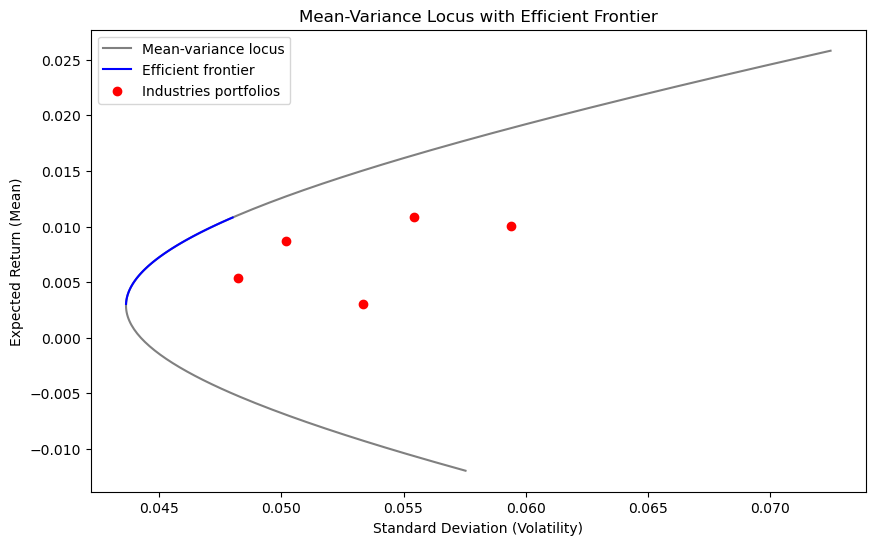

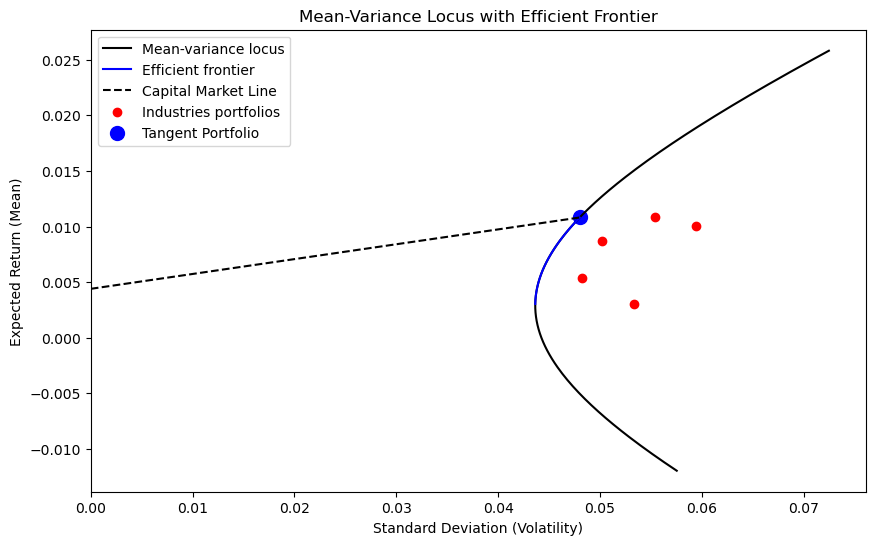

In [3]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

# Number of bootstrap samples you want to generate
num_bootstrap_samples = 1

# Perform bootstrap sampling
bootstrap_samples = [df_5.sample(n=len(df_5), replace=True) for _ in range(num_bootstrap_samples)]

# Now bootstrap_samples is a list of DataFrames, each containing rows sampled with replacement from the original DataFrame.

# Concatenate the list of DataFrames into a single DataFrame
bootstrap_df = pd.concat(bootstrap_samples)

# Reset the index if needed
bootstrap_df.reset_index(drop=True, inplace=True)

bootstrap_df = bootstrap_df.values / 100

sigma_boot = np.cov(bootstrap_df, rowvar=False)

z_barre = np.mean(bootstrap_df, axis=0)
Z_barre = z_barre  # Rendements espérés des actifs
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Inversion de la matrice de covariance
Sigma_inv = np.linalg.inv(sigma_boot)

# Construction de la matrice A et du vecteur b
A = np.array([
    [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
    [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
])
b = np.array([1, R_cible])

# Inversion de la matrice A
A_inv = np.linalg.inv(A)

# Résolution pour obtenir les multiplicateurs de Lagrange
lambda_theta = np.dot(A_inv, b)

# Calcul des poids optimaux du portefeuille
w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

print("Lambda (lambda_theta[0]) :", lambda_theta[0])
print("Theta (lambda_theta[1]) :", lambda_theta[1])
print("Poids optimaux du portefeuille :", w_optimal)

# Intervalle des rendements cibles pour la frontière efficiente
rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []

for R_cible in rendements_cibles_efficients:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
    rendements_optimaux.append(rendement_optimal)
    volatilites_optimales.append(volatilite_optimale)

# Étendre l'intervalle des rendements cibles pour la frontière complète
rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

# Calcul des volatilités et des rendements pour la frontière complète
volatilites_optimales_etendues = []
rendements_optimaux_etendus = []
for R_cible in rendements_cibles_etendus:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_boot, wi_optimal)))
    rendements_optimaux_etendus.append(rendement_optimal)
    volatilites_optimales_etendues.append(volatilite_optimale)


# Risk-free rate (you need to define your risk-free rate)
rf = 0.0044

# Calculate the slope of the CML
CML_slope = (max(rendements_optimaux) - rf) / max(volatilites_optimales)

# Generate standard deviations for the CML
CML_std = np.linspace(0, max(volatilites_optimales), 100)

# Calculate corresponding expected returns for the CML
CML_ret = rf + CML_slope * CML_std

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='grey')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.scatter(np.sqrt(np.diag(sigma_boot)), Z_barre, color='red', label='Industries portfolios')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.show()

# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='black')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
plt.scatter(np.sqrt(np.diag(sigma_boot)), Z_barre, color='red', label='Industries portfolios')
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.xlim(0)
plt.show()


In [4]:
# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the weights of the tangent portfolio
tangent_portfolio_weights = wi_optimal 

# Calculate the mean (expected return) of the tangent portfolio
tangent_portfolio_mean = rendements_optimaux[max_sharpe_index]

# Calculate the variance of the tangent portfolio
tangent_portfolio_variance = volatilites_optimales[max_sharpe_index] ** 2

# Print or use these values as needed
print("Tangent Portfolio Mean:", tangent_portfolio_mean)
print("Tangent Portfolio Variance:", tangent_portfolio_variance)
print("Tangent Portfolio Weights:", tangent_portfolio_weights)

Tangent Portfolio Mean: 0.010814999999999998
Tangent Portfolio Variance: 0.0023045457269523437
Tangent Portfolio Weights: [-2.57716293  0.34057752  1.88940247  0.53845569  0.80872725]


## Numérique